## Example of using IVcorrection class

IVcorrection class can correct I-V curves using 4 correction procedures:

- Procedure 1 of IEC 60891:2021 [1]
- Procedure 2 of IEC 60891:2021 [1]
- Procedure 4 of IEC 60891:2021 [1]
- Procedure dynamic

There are 4 steps to follow to run the example:

- Step 1: Input the PV module parameters
- Step 2: Obtain correction coefficients of Procedure 1 and 2
- Step 3: Simulate and plot example I-V curves
- Step 4: Correct the I-V curves using 4 methods and plot the corrected curves

References:

[1] IEC 60891:2021, Photovoltaic devices - Procedures for temperature and irradiance corrections to measured I-V characteristics

In [1]:
import numpy as np
from IVcorrection import get_P1_coefs, get_P2_coefs
from IVcorrection import get_corrected_IV_P1, get_corrected_IV_P2, get_corrected_IV_P4, get_corrected_IV_Pdyna
from IVcorrection import simu_IV_curve
from IVcorrection import plot_iv_raw, plot_iv_corrected, plot_iv_corrected_quad
from pvlib.pvsystem import retrieve_sam

### Step 1: Input PV module parameters


To obtain correction coefficients, the following PV module parameters are required, which can be obtained from module datasheet:

- N_cells: integer
        Number of cell in the module.
- Voc_ref: float
        Open-circuit voltages at standard test condition (STC) [V]
- Isc_ref: float
        Short-circuit current at STC [A]
- alpha_isc_abs : float
        Absolute temperature coefficient of short-circuit current (A/C)
- beta_voc_abs : float
        Absolute temperature coefficient of open circuit voltage [V/C]
- alpha_isc_rel : float
        Relative temperature coefficient of short circuit current [A/%]
- beta_voc_rel : float
        Relative temperature coefficient of open circuit voltage [V/%]

Besides, the five single-diode model (SDM) parameters are also needed:

- I_L_ref: float
Light-generated current at reference conditions [A]
- I_o_ref: float
Diode saturation current at reference conditions [A]
- R_s: float
Series resistance [ohm]
- R_sh_ref: float
Shunt resistance at reference conditions [ohm]
- a_ref: float
Modified ideality factor at reference conditions.
The product of the usual diode ideality factor (n, unitless),
number of cells in series (Ns), and cell thermal voltage at
specified effective irradiance and cell temperature

The SDM parameters can be obtained by using 'pvlib.ivtools.sdm.fit_cec_sam' [1] or 'pvlib.ivtools.sdm.fit_desoto' [2] function.

Reference
[1] A. Dobos, “An Improved Coefficient Calculator for the California Energy Commission 6 Parameter Photovoltaic Module Model”, Journal of Solar Energy Engineering, vol 134, 2012.
[2] W. De Soto et al., “Improvement and validation of a model for photovoltaic array performance”, Solar Energy, vol 80, pp. 78-88, 2006.


In [2]:
paras = retrieve_sam('CECmod')['Sharp_NU_U235F2']

In [3]:
N_cells = paras['N_s']
Voc_ref = paras['V_oc_ref']
Isc_ref = paras['I_sc_ref']
alpha_isc_rel = paras['alpha_sc']/paras['I_sc_ref']
beta_voc_rel = paras['beta_oc']/paras['V_oc_ref']
alpha_isc_abs = paras['alpha_sc']
beta_voc_abs = paras['beta_oc']

SDMparams = {'I_L_ref': paras['I_L_ref'], 
             'I_o_ref': paras['I_o_ref'], 
             'R_s': paras['R_s'], 
             'R_sh_ref': paras['R_sh_ref'], 
             'a_ref':paras['a_ref']}

### Step 2: Obtain correction coefficients of Procedure 1 and 2

In [4]:
coefs_P1 = get_P1_coefs(alpha_isc_abs, beta_voc_abs, SDMparams)
coefs_P2 = get_P2_coefs(alpha_isc_abs = alpha_isc_abs,
                        alpha_isc_rel= alpha_isc_rel,
                        beta_voc_rel= beta_voc_rel,
                        voc_ref= Voc_ref,
                        SDMparams= SDMparams)
coefs_P1

{'rs': 0.32999999999999985, 'k': 0.0048000000000000004}

In [5]:
coefs_P2

{'B1': 0.042381491309363604,
 'B2': 0.0018961112354697748,
 'rs': 0.29999999999999993,
 'k': 0.0041}

### Step 3: Simulate and plot example I-V curves

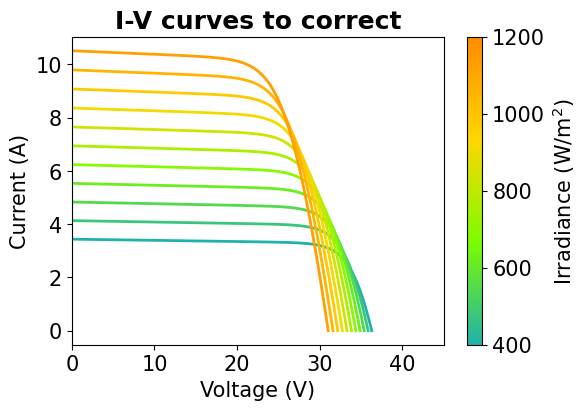

In [6]:
T = np.arange(20, 71, 50/10)
G = np.arange(400, 1201, 800/10)

# T = 30
# G = 800

iv_raw = simu_IV_curve(G, T, alpha_isc_abs, SDMparams)
iv_ref = simu_IV_curve([1000], [25], alpha_isc_abs, SDMparams)
plot_iv_raw(iv_raw, title= 'I-V curves to correct')

### Step 4: Correct the I-V curves using 4 methods and plot the corrected curves

In [7]:
iv_P1 = get_corrected_IV_P1(iv_raw, alpha_isc_abs, beta_voc_abs, **coefs_P1)
iv_P2 = get_corrected_IV_P2(iv_raw, alpha_isc_rel, beta_voc_rel, Voc_ref, **coefs_P2)
iv_P4 = get_corrected_IV_P4(iv_raw, alpha_isc_abs, N_cells)
iv_Pdyna = get_corrected_IV_Pdyna(iv_raw, alpha_isc_rel, beta_voc_rel, Voc_ref, **coefs_P2) # Pdyna uses partial coefficients of P2

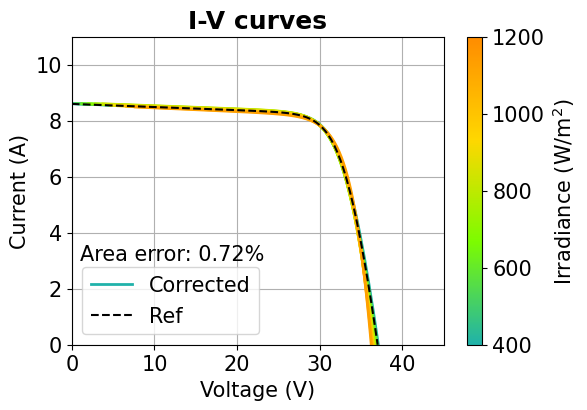

In [8]:
plot_iv_corrected(iv_Pdyna, iv_ref, plot_ref = True, xmax=45, ymax=11)

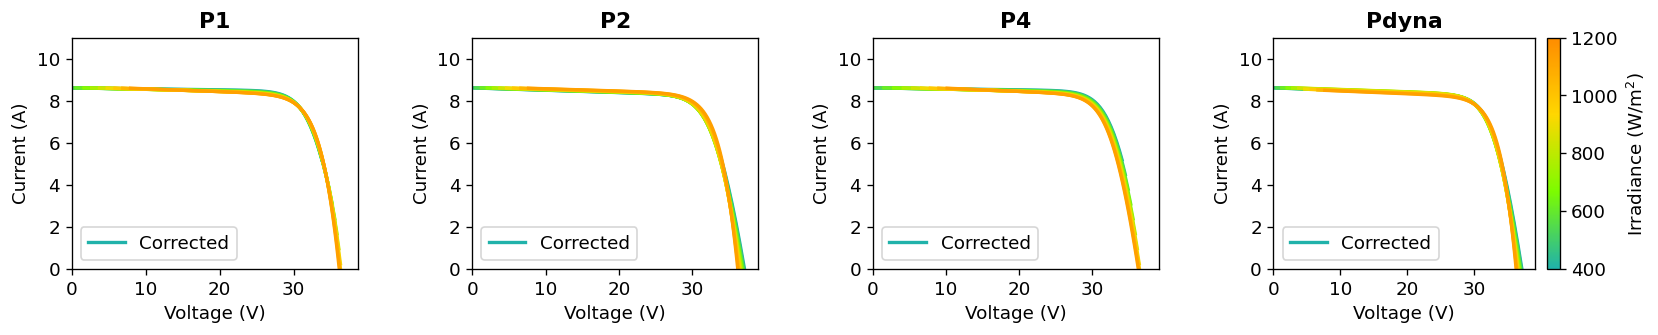

In [9]:
plot_iv_corrected_quad(iv_P1, iv_P2, iv_P4, iv_Pdyna, iv_ref, ymax = 11)